In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Data
$y=ax^2+bx+c$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


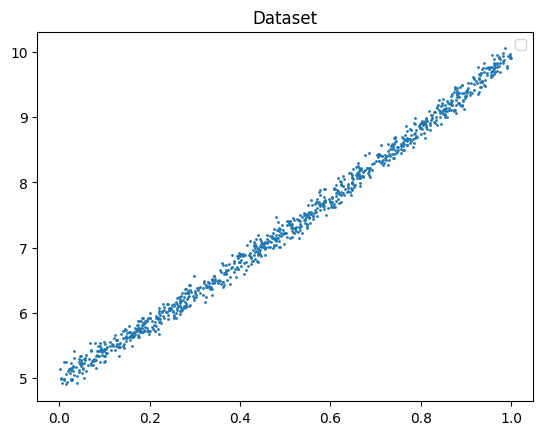

In [49]:
f = lambda x: x**2 + x*4 + 5.0 # 2x + 1 
noise = 0.1
xs = np.random.rand(1000, 1)   # 1000 points
ys = f(xs) + noise*np.random.randn(1000, 1) # 노이즈 추가 

plt.title("Dataset")
plt.scatter(xs, ys, s=1)
#plt.plot(xs, f(xs), label=f"y = x^2 + 4x + 5")
plt.legend()
plt.show()

# Model

* A model is a mathematical function $f_{\theta}:\mathbb R\rightarrow \mathbb R$ with some parameters $\theta=\{a, b\}$.
* We need:
  * a function $f$,
  * a way to set and get parameters,
  * a way to process a bunch (called a batch) of inputs.

In [20]:
class Module:
  def __init__(self) -> None:
    raise NotImplementedError

  def set_params(self) -> None:
    raise NotImplementedError
  
  def get_params(self) -> dict:
    raise NotImplementedError
  
  def forward(self, x:np.array) -> np.array:
    raise NotImplementedError
  
  def __call__(self, x:np.array) -> np.array:
    return self.forward(x)

In [21]:
class LinearModel(Module): 
  def __init__(self, w:float=.0, b:float=.0) -> None:
    self.set_params(w, b)

  def set_params(self, w:float, b:float) -> None:
    self.w = w
    self.b = b

  def get_params(self) -> dict[str,float]:
    return {'w': self.w, 'b':self.b}

  def forward(self, x:np.array) -> np.array:
    params = self.get_params()
    w = params.get('w')
    b = params.get('b')
    return w * x + b

In [22]:
class PolynomialModel(Module): # Polynomial

  # Initialize Polynomial model (y = w1_x^2 + w2_x + b)
  def __init__(self, w1:float=.0, w2:float=.0, b:float=.0) -> None:
    self.set_params(w1,w2,b)

  def set_params(self, w1:float, w2:float, b:float) -> None:
    self.w1 = w1
    self.w2 = w2
    self.b = b

  def get_params(self) -> dict[str,float]:
    return {'w1': self.w1, 'w2': self.w2, 'b':self.b}

  def forward(self, x:np.array) -> np.array:
    params = self.get_params()
    w1 = params.get('w1')
    w2 = params.get('w2')
    b = params.get('b')
    return w1 * (x**2) + w2*x  + b

In [23]:
def mse(y_hat:np.array, y_true:np.array) -> float:
  # y_hat: predicted value
  # y_true: true value
  assert len(y_hat) == len(y_true)
  return ((y_hat - y_true)**2).mean()

In [6]:
pol = PolynomialModel(1,4,5) # 

In [24]:
mse(pol(xs), ys)

0.0

$$\frac{\partial}{\partial w_1} \operatorname{MSE}_{\theta}(x,y) = \frac{2}{n}\sum^n_{i=1}x_i^2(x^2w_1+x_iw_2+b - y_i)=\frac{2}{n}\sum^n_{i=1}x_i^2(\hat y_i - y_i).$$

$$\frac{\partial}{\partial w_2} \operatorname{MSE}_{\theta}(x,y) = \frac{2}{n}\sum^n_{i=1}x_i(x^2w_1+x_iw_2+b - y_i)=\frac{2}{n}\sum^n_{i=1}x_i(\hat y_i - y_i).$$

$$\frac{\partial}{\partial b} \operatorname{MSE}_{\theta}(x,y) = \frac{2}{n}\sum^n_{i=1}(x_iw+b - y_i)= \frac{2}{n}\sum^n_{i=1}(\hat y_i - y_i).$$

In [33]:
def grad_mse(model:Module, x:np.array, y_true:np.array) -> dict[str,float]:
  assert len(x) == len(y_true)
  n = len(x)
  y_hat = model(x)
  d_w1 = 2*((x**2)*(y_hat-y_true)).mean() 
  d_w2 = 2*(x*(y_hat-y_true)).mean()
  d_b = 2*(y_hat-y_true).mean()
  return {'d_w1': d_w1, 'd_w2':d_w2, 'd_b':d_b}

In [26]:
pol2 = PolynomialModel(0,0,0)
grad_mse(pol2, xs, ys)

{'d_w1': -5.6584614264873,
 'd_w2': -8.075961161341377,
 'd_b': -14.618939089866846}

* Update $\theta=\{w_1,w_2,b\}$: $$\theta_{\textrm{new}} = \theta_{\textrm{old}} - \alpha \nabla\operatorname{MSE}_{\theta_{\textrm{old}}}(x,y)$$ where $\alpha>0$ is a learning rate.

In [27]:
def update(model:Module, lr:float, d_w1:float, d_w2:float, d_b:float) -> None:
  params_old = model.get_params()
  params_new = {
    'w1': params_old.get('w1') - lr*d_w1,
    'w2': params_old.get('w2') - lr*d_w2,
    'b': params_old.get('b') - lr*d_b,
  }
  model.set_params(**params_new)

In [28]:
pol2.get_params()

{'w1': 0, 'w2': 0, 'b': 0}

In [29]:
update(pol2, lr=0.001, **grad_mse(pol2, xs, ys))

In [30]:
pol2.get_params()

{'w1': 0.0056584614264872995,
 'w2': 0.008075961161341377,
 'b': 0.014618939089866846}

In [48]:
history = [pol2.get_params()]

for epoch in range(200):
  grad = grad_mse(pol2, xs, ys)
  update(pol2, 0.2, **grad)
  err = mse(pol2(xs), ys)
  params = pol2.get_params()
  history.append(params)
  print(f"Epoch {epoch+1}: mse={err:.4f}, w1={params.get('w1'):.4f}, w2={params.get('w2'):.4f}b={params.get('b'):.4f}")

Epoch 1: mse=0.0000, w1=1.0521, w2=3.9463b=5.0096
Epoch 2: mse=0.0000, w1=1.0520, w2=3.9463b=5.0096
Epoch 3: mse=0.0000, w1=1.0520, w2=3.9464b=5.0096
Epoch 4: mse=0.0000, w1=1.0519, w2=3.9465b=5.0096
Epoch 5: mse=0.0000, w1=1.0518, w2=3.9465b=5.0096
Epoch 6: mse=0.0000, w1=1.0518, w2=3.9466b=5.0096
Epoch 7: mse=0.0000, w1=1.0517, w2=3.9466b=5.0095
Epoch 8: mse=0.0000, w1=1.0517, w2=3.9467b=5.0095
Epoch 9: mse=0.0000, w1=1.0516, w2=3.9467b=5.0095
Epoch 10: mse=0.0000, w1=1.0516, w2=3.9468b=5.0095
Epoch 11: mse=0.0000, w1=1.0515, w2=3.9469b=5.0095
Epoch 12: mse=0.0000, w1=1.0515, w2=3.9469b=5.0095
Epoch 13: mse=0.0000, w1=1.0514, w2=3.9470b=5.0095
Epoch 14: mse=0.0000, w1=1.0514, w2=3.9470b=5.0095
Epoch 15: mse=0.0000, w1=1.0513, w2=3.9471b=5.0095
Epoch 16: mse=0.0000, w1=1.0512, w2=3.9471b=5.0095
Epoch 17: mse=0.0000, w1=1.0512, w2=3.9472b=5.0094
Epoch 18: mse=0.0000, w1=1.0511, w2=3.9473b=5.0094
Epoch 19: mse=0.0000, w1=1.0511, w2=3.9473b=5.0094
Epoch 20: mse=0.0000, w1=1.0510, w2=3.94

```bash
conda activate MathAI
pip install pandas plotly nbformat
```

In [ ]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame(history, columns=['w','b'])
df = df.set_index(df.index.set_names('epoch')).reset_index()
df0 = df.copy()
df1 = df.copy()
df0['x'] = xs.min()
df1['x'] = xs.max()
df = pd.concat([df0, df1]).reset_index(drop=True)
df['y'] = df.w * df.x + df.b

fig = px.line(df, x='x', y='y', animation_frame="epoch", width=500, height=500)

fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 0.1
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 0.1
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['redraw'] = True

fig.add_scatter(x=xs.flatten(), y=ys.flatten(), mode='markers', name='data', marker={'size':2})

for i, frame in enumerate(fig.frames):
    frame['layout']['title_text'] = f"Prediction: y = {history[i]['w']:.4f}x{'' if history[i]['b'] < 0 else '+'}{history[i]['b']:.4f}"

fig.update_layout(template='plotly_dark')
fig.show()